In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer, make_column_selector

from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, precision_recall_curve, confusion_matrix
from sklearn.metrics import balanced_accuracy_score
from imblearn.metrics import geometric_mean_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.feature_selection import SelectKBest, VarianceThreshold, chi2

from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDClassifier

import shap

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
acc_dtypes = {
    "place":"category",
    "catu":"category",
    "grav":"category",
    "sexe":"category",
    "trajet":"category",
    "locp":"category",
    "actp":"category",
    "etatp":"category",
    "secuUn":"category",
    "secuDeux":"category",
    "tranches_ages":"category",
    "catr":"category",
    "circ":"category",
    "vosp":"category",
    "prof":"category",
    "plan":"category",
    "surf":"category",
    "infra":"category",
    "situ":"category",
    "senc":"category",
    "obs":"category",
    "obsm":"category",
    "choc":"category",
    "manv":"category",
    "catv_Label":"category",
    "lum":"category",
    "agg":"category",
    "int":"category",
    "atm":"category",
    "col":"category",
    "jour_de_la_semaine":"category",
    "heure":"category",
    "dep": "category"
    }
df = pd.read_csv(r"C:\Users\maill\Documents\GitHub\SARA\data\fusion3.csv", low_memory=False)
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df = df.drop(['Unnamed: 0','num_acc','an_nais','an_naiss','age_acc_an','num_veh','senc','occutc','permis','secuDeux','date','com'], axis=1)
df['place'] = df['place'].astype('object')
df['dep'] = df['dep'].replace({'2A':201,'2B':202})
df['dep'] = df['dep'].astype('int64')

df = df.dropna()

In [3]:
X = df.drop('grav',axis=1)
y = df['grav']

ohe = OneHotEncoder()
# categorical_variable = make_column_selector(dtype_exclude=np.number)
X = ohe.fit_transform(X)


X, _, y, _ = train_test_split(X, y, stratify=y, test_size=0.954, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X.shape)

ros = RandomOverSampler(random_state=42)
X_train, y_train = ros.fit_resample(X_train, y_train)

rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

print(X_train.shape)

(105420, 481)
(138152, 481)


In [ ]:
# categorical_variable = make_column_selector(dtype_exclude=np.number)
# encoder = make_column_transformer((OneHotEncoder(), categorical_variable))

# model = ImbPipeline(steps=[('transformer', encoder),('undersampling', RandomUnderSampler(random_state=42)),('classifier', RandomForestClassifier(random_state=42))], verbose=True)




# Recherche des meilleurs paramètres
objectifs : reduire l'overfitting et optimiser la performance du modèle grâce au f1_score

In [5]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

# Grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [int(x) for x in np.linspace(start = 10, stop = 100, num = 20)], # Nombre d'arbres
    'max_depth': [int(x) for x in np.linspace(10, 50, num = 11)], # Profondeur maximale de l'arbre
    'min_samples_split': [2, 5, 10], # Nombre minimum d'échantillons requis pour diviser un nœud
    'min_samples_leaf': [2, 4, 6], # Nombre minimum d'échantillons requis à chaque nœud feuille
    'min_impurity_decrease': [0.0, 0.01, 0.1], # Seuil pour une réduction minimale de l'impureté
    'ccp_alpha': [0.0, 0.01, 0.1] # Paramètre de complexité utilisé pour l'élagage minimal des coûts-complexité
}

# Créer le modèle de base à tuner
rf = RandomForestClassifier()

n_folds = StratifiedKFold(n_splits=3)

f1_scorer = make_scorer(f1_score, average='macro')

# rechercher dans 100 différentes combinaisons
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = param_grid,
                               n_iter = 10, cv = n_folds, scoring=f1_scorer, verbose=1, random_state=42, n_jobs = -1)

# Ajuster le modèle RandomizedSearchCV
rf_random.fit(X_train, y_train)

best_params = rf_random.best_params_

    # Afficher les meilleurs paramètres actuels
print(f"meilleurs paramètres: {best_params}")
print(f"meilleur score : {rf_random.best_score_})

Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters: {'n_estimators': 38, 'min_samples_split': 10, 'min_samples_leaf': 4, 'min_impurity_decrease': 0.0, 'max_depth': 42, 'ccp_alpha': 0.0}


0.7567262831900902

# Courbe d'apprentissage

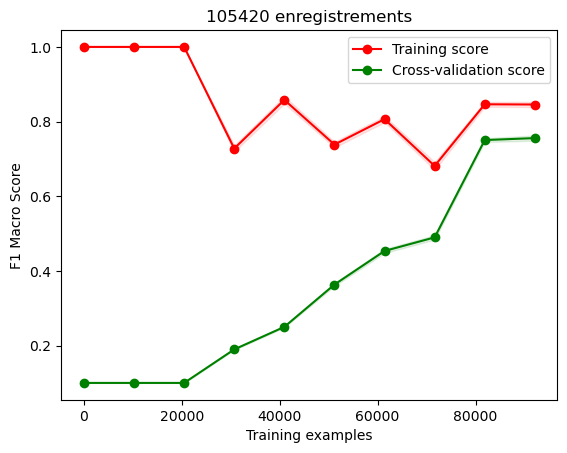

In [11]:
estimator = RandomForestClassifier(n_estimators= 38, min_samples_split= 10, min_samples_leaf= 4, min_impurity_decrease= 0.0,
                                   max_depth= 42, ccp_alpha= 0.0)
train_scores = []
test_scores = []
n_folds = StratifiedKFold(n_splits=3)
# fonction learning_curve
train_sizes, train_scores, test_scores = learning_curve(estimator, X_train, y_train, cv=n_folds, scoring='f1_macro',
                                                        train_sizes=np.linspace(0.0001, 1.0, 10))

# Calculer la moyenne et l'écart type pour les scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Tracer les courbes d'apprentissage
plt.figure()
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
plt.title(f'{X.shape[0]} enregistrements')
plt.xlabel("Training examples")
plt.ylabel("F1 Macro Score")
plt.legend(loc="best")
plt.show()


In [7]:
estimator = RandomForestClassifier(n_estimators= 38, min_samples_split= 10, min_samples_leaf= 4, min_impurity_decrease= 0.0,
                                   max_depth= 42, ccp_alpha= 0.0)
estimator.fit(X_train, y_train)
y_pred = estimator.predict(X_test)
print(pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite']))
print(classification_report(y_test, y_pred))

Classe prédite      Blessé hospitalisé  Blessé léger  Indemne  Tué
Classe réelle                                                     
Blessé hospitalisé                2258          1198      593  217
Blessé léger                      1640          4019     1905   84
Indemne                            642           935     6959   62
Tué                                357            56       52  107
                    precision    recall  f1-score   support

Blessé hospitalisé       0.46      0.53      0.49      4266
      Blessé léger       0.65      0.53      0.58      7648
           Indemne       0.73      0.81      0.77      8598
               Tué       0.23      0.19      0.21       572

          accuracy                           0.63     21084
         macro avg       0.52      0.51      0.51     21084
      weighted avg       0.63      0.63      0.63     21084



# Precision Recall Curve

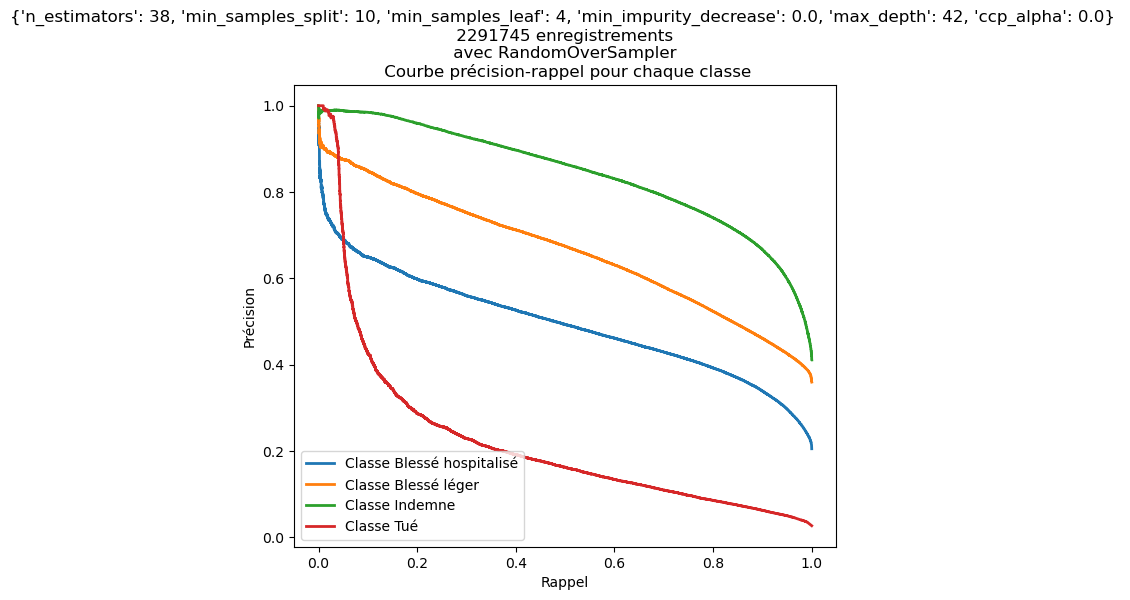

In [18]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# Initialiser le LabelEncoder
le = LabelEncoder()

# Ajuster le label encoder et transformer les étiquettes de classe en entiers
y_test_encoded = le.fit_transform(y_test)

# Ajuster le modèle et obtenir les probabilités prédites pour l'ensemble de test
y_proba = rf_random.predict_proba(X_test)

# Nombre de classes
n_classes = y_proba.shape[1]

# Binariser les étiquettes de classe pour correspondre à `y_proba`
from sklearn.preprocessing import label_binarize
y_test_binarized = label_binarize(y_test_encoded, classes=range(n_classes))

# Calcul de la précision et du rappel pour chaque classe
precision = dict()
recall = dict()
thresholds = dict()

for i in range(n_classes):
    precision[i], recall[i], thresholds[i] = precision_recall_curve(y_test_binarized[:, i], y_proba[:, i])

# Tracer les courbes de précision-rappel pour chaque classe
plt.figure(figsize=(7, 6))

for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Classe {le.classes_[i]}')

plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe précision-rappel pour chaque classe")
plt.legend(loc="best")
plt.show()


# interprétabilité

In [14]:
estimator = RandomForestClassifier(n_estimators= 38, min_samples_split= 10, min_samples_leaf= 4, min_impurity_decrease= 0.0,
                                   max_depth= 42, ccp_alpha= 0.0)

y_encoder = LabelEncoder()
y_train = y_encoder.fit_transform(y_train)
y_test = y_encoder.transform(y_test)

estimator.fit(X_train, y_train)

explainer = shap.TreeExplainer(estimator)

original_feature_names = ohe.get_feature_names_out()
X_encoded_df = pd.DataFrame.sparse.from_spmatrix(X_test, columns=original_feature_names)


In [ ]:
shap_values = explainer.shap_values(X_encoded_df)

In [33]:
from joblib import dump

# Sauvegarder les shap_values
dump(shap_values, 'shap_values.joblib')


['shap_values.joblib']

In [10]:
from joblib import load

shap_values = load('shap_values.joblib')


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


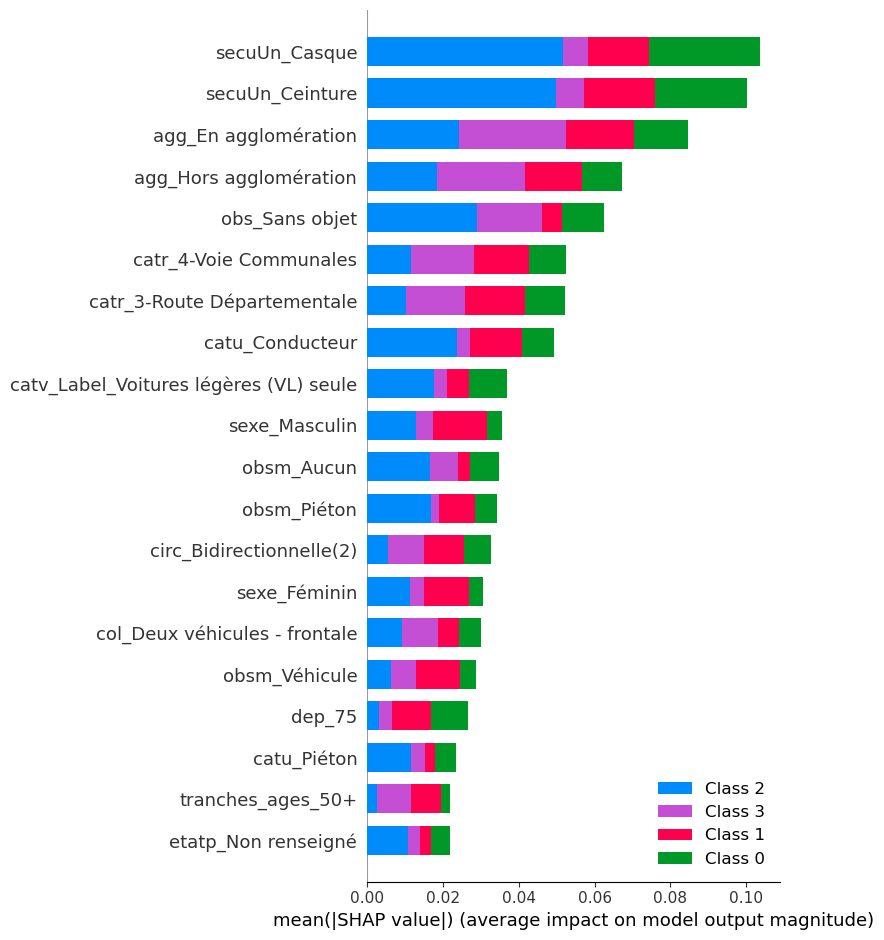

In [6]:
shap.summary_plot(shap_values, X_encoded_df)


ValueError: zero-size array to reduction operation minimum which has no identity

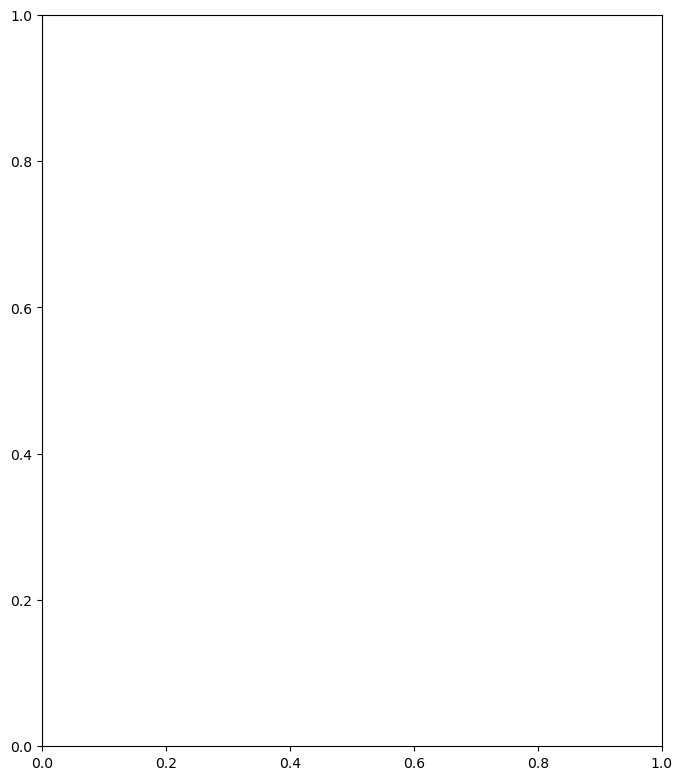

In [20]:
# Assurez-vous que 'shap_values' est la liste des valeurs SHAP pour toutes les classes, obtenue à partir de votre explainer SHAP.
class_index = 3

# Prédisez les classes et obtenez un booléen pour les instances correctement prédites.
correctly_predicted = y_pred == y_test

# Sélectionnez les valeurs SHAP pour les instances correctement prédites pour la classe en question.
correct_shap_values_for_class = shap_values[class_index][correctly_predicted]

# Créez le plot SHAP pour les instances correctement prédites pour la classe choisie.
shap.summary_plot(correct_shap_values_for_class, features=X_test[correctly_predicted])




In [16]:
shap.initjs()
# Sélectionnez un index d'échantillon (par exemple, le premier échantillon)
sample_index = 100

# Créez un force plot pour une instance spécifique
shap.force_plot(explainer.expected_value[3], shap_values[3][sample_index], X_encoded_df.iloc[sample_index])



In [17]:
y_pred = estimator.predict(X_test)
y_pred_original = y_encoder.inverse_transform(y_pred)
y_test_original = y_encoder.inverse_transform(y_test)

correct_indices = (y_pred_original == y_test_original) & (y_test_original == 'Tué')
incorrect_indices = (y_pred_original != y_test_original) & (y_test_original == 'Tué')

shap_values_correct = shap_values[3][correct_indices]
shap_values_incorrect = shap_values[3][incorrect_indices]



In [ ]:

# Pour les instances correctes
correct_indices_sample = np.random.choice(np.where(correct_indices)[0], 5, replace=False)
shap_values_correct_sample = shap_values[3][correct_indices_sample]



shap.force_plot(explainer.expected_value[3], shap_values_correct_sample, X_encoded_df.iloc[correct_indices_sample])

In [ ]:
shap.force_plot(explainer.expected_value[3], shap_values_incorrect, X_encoded_df.iloc[incorrect_indices])


In [8]:
pip install skater

  Using cached skater-1.1.2.tar.gz (96 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached scikit-image-0.14.0.tar.gz (27.0 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached ds_lime-0.1.1.27-py3-none-any.whl
  Using cached wordcloud-1.3.1.tar.gz (169 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached joblib-0.11-py2.py3-none-any.whl (176 kB)
  Using cached Jinja2-2.10-py2.py3-none-any.whl (126 kB)
  Using cached pydotplus-2.0.2-py3-none-any.whl
  Using cached bs4-0.0.1-py3-none-any.whl
INFO: pip is looking at multiple versions of scikit-learn to determine which version is compatible with other requirements. This could take a while.
     ---------------------------------------- 0.0/8.4 MB ? eta -:--:--
     ---------------------------------------- 0.0/8.4 MB 660.6 kB/s eta 0:00:13

  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [403 lines of output]
  C:\Users\maill\anaconda3\lib\site-packages\setuptools\dist.py:745: SetuptoolsDeprecationWarning: Invalid dash-separated options
  !!
  
          ********************************************************************************
          Usage of dash-separated 'description-file' will not be supported in future
          versions. Please use the underscore name 'description_file' instead.
  
          This deprecation is overdue, please update your project and remove deprecated
          calls to avoid build errors in the future.
  
          See https://setuptools.pypa.io/en/latest/userguide/declarative_config.html for details.
          ********************************************************************************
  
  !!
    opt = self.warn_dash_deprecation(opt, section)
  running bdist_wheel
  running build
  running build_py
  creating build

In [9]:
from skater.model import InMemoryModel
from skater.core.explanations import Interpretation
from skater.core.local_interpretation.lime.lime_tabular import LimeTabularExplainer

X_train_dense = X_train.toarray()
X_test_dense = X_test.toarray()


model_skater = InMemoryModel(estimator.predict_proba, examples=X_train_dense)

explainer = LimeTabularExplainer(X_train_dense.values, feature_names=X_train_dense.columns, class_names=class_names, mode='classification')

instance_to_explain = X_test_dense.values[0]

exp = explainer.explain_instance(instance_to_explain, model_skater.predict_proba, num_features=5)
exp.show_in_notebook()


ModuleNotFoundError: No module named 'skater'